In [1]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load dataset from Hugging Face
dataset = load_dataset("Hemg/Deepfake-Audio-Dataset")

# To Initialize containers
audio_signals = []
labels = []

# Convert dataset to audio arrays
for sample in dataset['train']:
    audio = np.array(sample['audio']['array'], dtype=np.float32)
    audio = librosa.util.fix_length(audio, size=22050)  # 1 second
    audio_signals.append(audio)
    labels.append(sample['label'])  # 0: real, 1: fake

labels = np.array(labels)

In [3]:
def extract_features(audio, sr=22050):
    features = []

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfccs, axis=1))

    # Spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    features.extend(np.mean(spectral_contrast, axis=1))

    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zcr))

    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features.extend(np.mean(chroma, axis=1))

    return np.array(features, dtype=np.float32)

# Applying feature extraction
features = np.array([extract_features(audio) for audio in audio_signals])


In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [6]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



In [7]:
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print(" Training complete")

Training Random Forest Classifier...
 Training complete


Confusion Matrix:
 [[8 2]
 [1 9]]


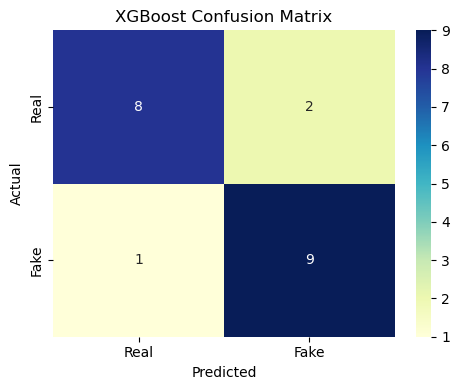

In [8]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
labels_names = ['Real', 'Fake']
df_cm = pd.DataFrame(cm, index=labels_names, columns=labels_names)
plt.figure(figsize=(5, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("xgboost_confusion_matrix.png")
plt.show()

In [9]:
print("\n Evaluation Results:")
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



 Evaluation Results:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20

Confusion Matrix:
 [[7 3]
 [1 9]]


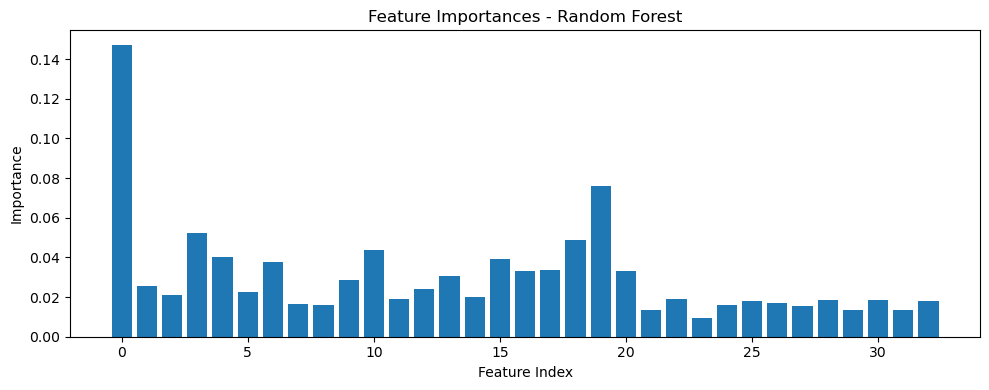

In [10]:
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

In [11]:
print("Training SVM Classifier...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)
print("Training complete")

Training SVM Classifier...
Training complete


In [12]:
print("\nEvaluation Results:")
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Evaluation Results:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20

Confusion Matrix:
 [[5 5]
 [1 9]]


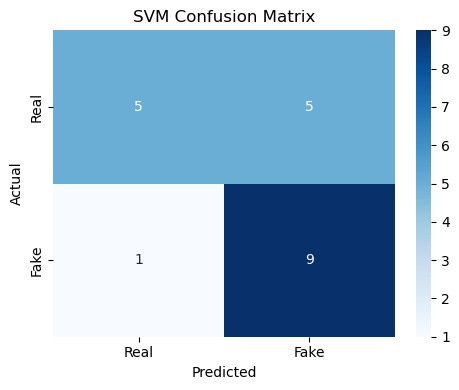

In [13]:
cm = confusion_matrix(y_test, y_pred)
labels_names = ['Real', 'Fake']
df_cm = pd.DataFrame(cm, index=labels_names, columns=labels_names)
plt.figure(figsize=(5, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("svm_confusion_matrix.png")
plt.show()